In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from meteostat import Stations, Daily


In [5]:
weather_station_raw = pd.read_csv('StormVistaData/all-stations_northamerica.csv')

In [15]:
stations_id = weather_station_raw['station'].unique()

In [16]:
stations = Stations()
stations = stations.nearby(32.63, -114.62) # arbitrary starting location

In [17]:
stations = stations.fetch()

In [37]:
display(stations)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
72280,Yuma / Yuma International,US,AZ,72280,KYUM,32.6500,-114.6000,65.0,America/Phoenix,1942-01-16,2007-01-05,1942-11-02,2006-12-25,1942-01-01,1995-01-01,2.907353e+03
KNYL0,Yuma / Desert Royal Mobile Park,US,AZ,<NA>,KNYL,32.6566,-114.6060,65.0,America/Phoenix,1988-01-01,2023-07-10,1988-01-01,2022-04-24,1988-01-01,2020-01-01,3.235241e+03
CDCYH,Yuma Auxiliary Airfield,US,AZ,<NA>,KNOZ,32.5000,-114.4500,105.0,America/Phoenix,2022-04-23,2023-07-05,2022-04-24,2022-04-26,NaT,NaT,2.151186e+04
KLGF0,Yuma / Laguna,US,AZ,<NA>,KLGF,32.8600,-114.3967,132.0,America/Phoenix,2020-01-14,2023-07-09,2020-01-15,2022-04-24,NaT,NaT,3.301838e+04
76005,Mexicali / Islas Agrarias Grupo B,MX,BCN,76005,MMML,32.6306,-115.2415,22.0,America/Tijuana,1990-03-14,2023-07-10,2020-03-10,2020-03-12,NaT,NaT,5.820016e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61984,Saint-Pierre,RE,<NA>,61984,FMEP,-21.3333,55.4833,52.0,Indian/Reunion,1973-01-02,2023-07-10,2013-03-10,2022-04-25,2015-01-01,2022-01-01,1.842337e+07
61995,Vacoas Mauritius,MU,PW,61995,<NA>,-20.3000,57.5000,423.0,Indian/Mauritius,NaT,NaT,1961-01-01,2023-07-02,1961-01-01,2021-01-01,1.843690e+07
61990,Plaisance Mauritius,MU,GP,61990,FIMP,-20.4333,57.6667,55.0,Indian/Mauritius,1949-02-01,2023-07-10,1951-01-01,2023-07-02,1951-01-01,2021-01-01,1.845814e+07


In [38]:
features = ['icao', 'latitude', 'longitude','elevation' ,'name', 'region', 'timezone']
station_df = pd.DataFrame(columns=features)

for station in stations_id:
    temp = stations[stations['icao'] == station]
    station_df = pd.concat([station_df, temp[features]])

In [52]:
display(station_df)

,icao,latitude,longitude,elevation,name,region,timezone
72529,KROC,43.1167,-77.6833,170.0,Greater Rochester International,NY,America/New_York
TMT7J,KDDH,42.8935,-73.2486,252.0,Bennington Morse State Airport,VT,America/New_York
KITR0,KITR,39.2425,-102.2854,1286.0,Burlington / West Burlington,CO,America/Denver
KOTM0,KOTM,41.1066,-92.4479,258.0,Ottumwa / Keb (Historical),IA,America/Chicago
72280,KYUM,32.6500,-114.6000,65.0,Yuma / Yuma International,AZ,America/Phoenix
...,...,...,...,...,...,...,...
72616,KBML,44.5833,-71.0167,353.0,Berlin Municipal Airport,NH,America/New_York
72458,KCNK,39.5500,-97.6500,453.0,"Concordia, Blosser Municipal Airport",KS,America/Chicago
72450,KICT,37.6500,-97.1000,406.0,Wichita Mid-Continent Airport,KS,America/Chicago
74756,KGNV,29.6901,-82.2718,46.0,Gainesville / Brittany Estates Mobile Home Park,FL,America/New_York


In [87]:
id = 'KHOU'
d = station_df.loc[station_df['icao'] == id]
display(d)

,icao,latitude,longitude,elevation,name,region,timezone
SC9N0,KHOU,29.6375,-95.2825,14.0,Houston Hobby Airport,TX,America/Chicago


Text(0.5, 1.0, 'Ineichen, climatological turbidity (Calgary)')

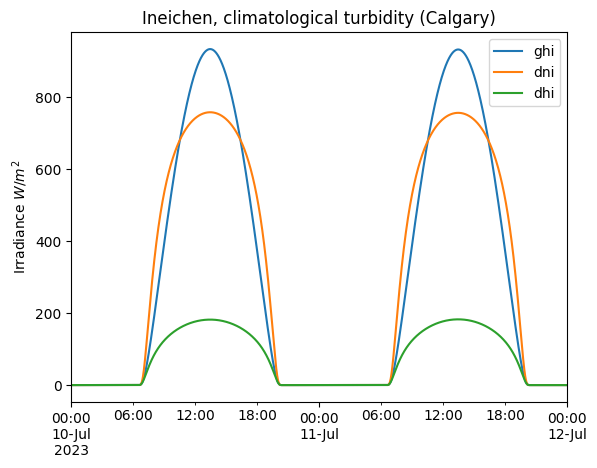

In [88]:
tus = Location(d['latitude'][0], d['longitude'][0], d['timezone'][0], d['elevation'][0])

times = pd.date_range(start='2023-07-10', end='2023-07-12', freq='1min', tz=tus.tz)

cs = tus.get_clearsky(times)  # ineichen with climatology table by default

cs.plot();
plt.ylabel('Irradiance $W/m^2$');
plt.title('Ineichen, climatological turbidity (Calgary)')

<Figure size 640x480 with 0 Axes>

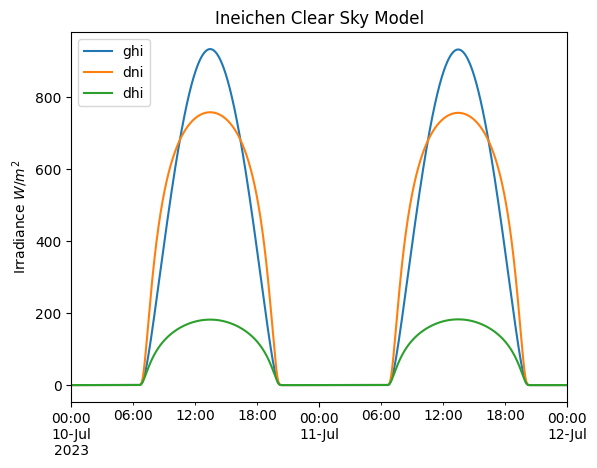

In [89]:
latitude, longitude, tz, altitude, name = d['latitude'][0], d['longitude'][0], d['timezone'][0], d['elevation'][0], id

times = pd.date_range(start='2023-07-10', end='2023-07-12', freq='1Min', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

apparent_zenith = solpos['apparent_zenith']

airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)

pressure = pvlib.atmosphere.alt2pres(altitude)

airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)

linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)

dni_extra = pvlib.irradiance.get_extra_radiation(times)

# an input is a pandas Series, so solis is a DataFrame
ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)

plt.figure();

ax = ineichen.plot()

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Ineichen Clear Sky Model');

ax.legend(loc=2);

In [90]:
data = pd.read_csv('StormVistaData/all-stations_northamerica.csv')

In [91]:
kroc = data[data['station'] == id]
kroc.index = kroc['fhr']

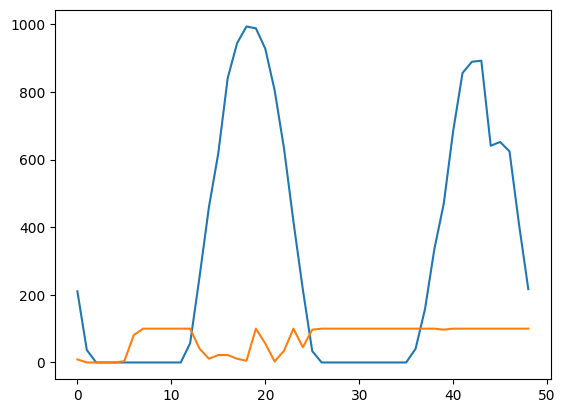

In [92]:
plt.plot(kroc['solar'])
plt.plot(kroc['cloudtotal'])

In [93]:
data['solar'].max()

1088.0

In [94]:
ineichen['ghi'].max()

934.538641557541